# Wildfire Prediction Model

## 1. Importing Libraries

In [6]:
!pip install albumentations

  Using cached albumentations-1.4.18-py3-none-any.whl.metadata (32 kB)
  Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
  Using cached scikit_image-0.24.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached albucore-0.0.17-py3-none-any.whl.metadata (3.1 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.23.4-cp311-none-win_amd64.whl.metadata (6.7 kB)
  Using cached imageio-2.36.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2024.9.20-py3-none-any.whl.metadata (32 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached albumentations-1.4.18-py3-none-any.whl (224 kB)
Using

DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  You can safely remove it manually.

[notice] A new release of pip is available: 22.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import numpy as np
import pandas as pd
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations as A
import cv2

## 2. Create Dataframes

In [12]:
def create_df_img(filepath):
    """ 
    Create a DataFrame with the filepath and the labels of the pictures
    
    Args : filepath of the images
    Return : pandas dataframe     
    """
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)
    return df

In [13]:
train_dir = Path('IMG')
filepaths = list(train_dir.glob(r'**/*.jpg'))
val_dir = Path('IMG')
filepaths_valid = list(val_dir.glob(r'**/*.jpg'))

### Checking if DataFrame loaded correctly

In [14]:
df_train = create_df_img(filepaths)
df_valid = create_df_img(filepaths_valid)
df_train.head()

,Filepath,Label
0,"IMG\nowildfire\-113.91831,51.088925.jpg",nowildfire
1,"IMG\wildfire\-62.3956,50.2942.jpg",wildfire
2,"IMG\wildfire\-59.03238,51.85132.jpg",wildfire
3,"IMG\wildfire\-60.6867,50.26079.jpg",wildfire


In [15]:
df_valid.head()

,Filepath,Label
0,"IMG\nowildfire\-113.91831,51.088925.jpg",nowildfire
1,"IMG\wildfire\-59.03238,51.85132.jpg",wildfire
2,"IMG\wildfire\-62.3956,50.2942.jpg",wildfire
3,"IMG\wildfire\-60.6867,50.26079.jpg",wildfire


# 3. Data Augmentation

In [16]:
def augmentation(image):
    """
    Function for Augmenting Images
    """
    aug = A.Compose([
        A.Flip(),
        A.Rotate(limit=75,always_apply=True),
    ])
    augmented_image = aug(image=image)['image']
    return augmented_image

In [17]:
BATCH_SIZE = 256
# Creating Train Generator using Image Generator
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=augmentation)
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')

#Creating Validity Checker
val_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
val_generator = val_datagen.flow_from_dataframe(df_valid,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')

Found 4 validated image filenames belonging to 2 classes.
Found 4 validated image filenames belonging to 2 classes.


In [18]:
df_train.head()

,Filepath,Label
0,"IMG\nowildfire\-113.91831,51.088925.jpg",nowildfire
1,"IMG\wildfire\-62.3956,50.2942.jpg",wildfire
2,"IMG\wildfire\-59.03238,51.85132.jpg",wildfire
3,"IMG\wildfire\-60.6867,50.26079.jpg",wildfire


# MODEL BUILDING

In [19]:
shrink = 1e-3 
image_shape=plt.imread(df_train["Filepath"][0]).shape
model = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 32 , kernel_size = 2, activation = 'relu',
           kernel_regularizer = regularizers.l2(shrink)),
    MaxPooling2D(pool_size = 2),
    
    
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(100,activation='relu'),
    Dropout(0.4),
    Dense(2,activation='softmax')
])
model.summary()

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 349, 349, 8)         │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 174, 174, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 173, 173, 16)        │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 86, 86, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 85, 85, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │      16,934,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,967,714 (64.73 MB)

 Trainable params: 16,967,714 (64.73 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpoint = ModelCheckpoint('APP/models/model.keras',verbose=1, save_best_only= True)

early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)

optimizer = optimizers.Adam(learning_rate= 0.00001, weight_decay= 1e-5)

checkpoint = ModelCheckpoint('APP/models/model.keras',verbose=1, save_best_only= True)

early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)

optimizer = optimizers.Adam(learning_rate= 0.00001, weight_decay= 1e-5)

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam',
                    metrics=['AUC','acc'])


history = model.fit(train_generator,
                    epochs = 100,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100


C:\Users\Divyansh\AppData\Local\Temp\ipykernel_5836\1298099886.py:6: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),
C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.4375 - acc: 0.5000 - loss: 0.7175
Epoch 1: val_loss improved from inf to 0.62918, saving model to Flask_html/models/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - AUC: 0.4375 - acc: 0.5000 - loss: 0.7175 - val_AUC: 0.8125 - val_acc: 0.7500 - val_loss: 0.6292
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - AUC: 0.5625 - acc: 0.7500 - loss: 0.7730
Epoch 2: val_loss did not improve from 0.62918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - AUC: 0.5625 - acc: 0.7500 - loss: 0.7730 - val_AUC: 0.9375 - val_acc: 0.7500 - val_loss: 0.6873
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - AUC: 0.9375 - acc: 0.7500 - loss: 0.3608
Epoch 3: val_loss did not improve from 0.62918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - AUC: 0.9375 - acc: 0.7500 - loss: 0.3608 - val_AUC: 0.9375 - val_acc: 0.7500 - val_loss: 0.7109
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - AUC: 0.5625 - acc: 0.7500 - loss: 1.1943
Epoch 4: val_loss improved from 0.62918 to 

# 4. Saving the Model

In [46]:
model.save('APP/models/WildFireDetector.keras')

# 5. Visualisation

In [40]:
def draw_fire_bbox(image_path):
    """
    Draws a bounding box around the fire region in the satellite image and saves the fire mask.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to load the image from path: {image_path}")

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 0, 50], dtype=np.uint8)
    upper_bound = np.array([180, 50, 255], dtype=np.uint8)

    fire_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
    kernel = np.ones((5, 5), np.uint8)
    fire_mask = cv2.morphologyEx(fire_mask, cv2.MORPH_OPEN, kernel)
    fire_mask = cv2.morphologyEx(fire_mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(fire_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    bbox_output_path = f"APP/TestImg/{base_name}-bbox.jpg"
    mask_output_path = f"APP/TestImg//{base_name}-mask.jpg"

    cv2.imwrite(bbox_output_path, image)
    cv2.imwrite(mask_output_path, fire_mask)

    return bbox_output_path, mask_output_path


In [41]:
# bbox, mask = draw_fire_bbox('APP/TestImg/-62.39074,51.35761.jpg')
image_path = os.path.abspath('APP/TestImg/-62.39074,51.35761.jpg')
bbox, mask = draw_fire_bbox(image_path)

In [42]:
bb = cv2.imread(bbox)
mask = cv2.imread(mask)

In [44]:
# Convert the images from BGR to RGB (as OpenCV loads images in BGR by default)
bb_rgb = cv2.cvtColor(bb, cv2.COLOR_BGR2RGB)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

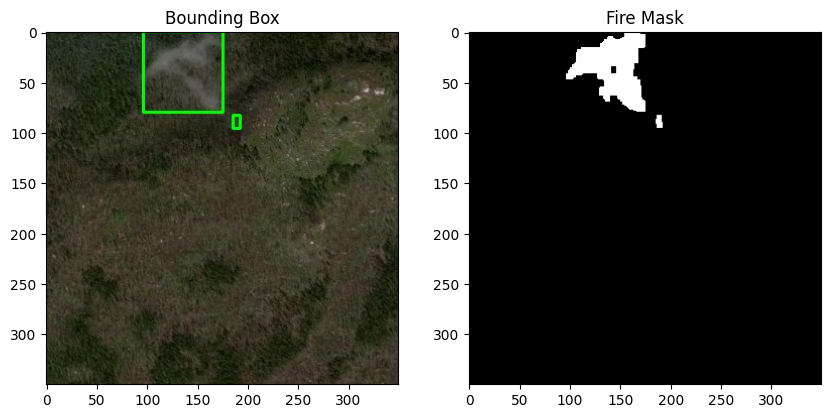

In [45]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(bb_rgb)
plt.title("Bounding Box")

plt.subplot(1, 2, 2)
plt.imshow(mask_rgb)
plt.title("Fire Mask")

plt.show()